Завантажуємо дані

In [ ]:
import warnings
warnings.simplefilter('ignore')
import plotly.graph_objs as go
import plotly.io as pio
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Thesis_2023/BTC_USD_FG_Ind.csv')
df['Date'] = pd.to_datetime(df['Date'])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,Open,High,Low,Close,Adj Close,Volume,FG_Index
0,2018-11-15,5736.149902,5774.819824,5358.379883,5648.029785,5648.029785,7.032140e+09,28
1,2018-11-16,5645.319824,5657.020020,5498.939941,5575.549805,5575.549805,5.279320e+09,23
2,2018-11-17,5578.580078,5578.580078,5519.560059,5554.330078,5554.330078,4.303150e+09,24
3,2018-11-18,5559.740234,5653.609863,5559.740234,5623.540039,5623.540039,4.159680e+09,26
4,2018-11-19,5620.779785,5620.779785,4842.910156,4871.490234,4871.490234,7.039560e+09,28


Трансформуємо датасет у необхідний вигляд

In [ ]:
df['weighted_price'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
df1 = df.drop(["Open", "High", "Low", "Close", "Adj Close"], axis=1)
df1.head()

,Date,Volume,FG_Index,weighted_price
0,2018-11-15,7.032140e+09,28,5629.344848
1,2018-11-16,5.279320e+09,23,5594.207397
2,2018-11-17,4.303150e+09,24,5557.762573
3,2018-11-18,4.159680e+09,26,5599.157592
4,2018-11-19,7.039560e+09,28,5238.989990


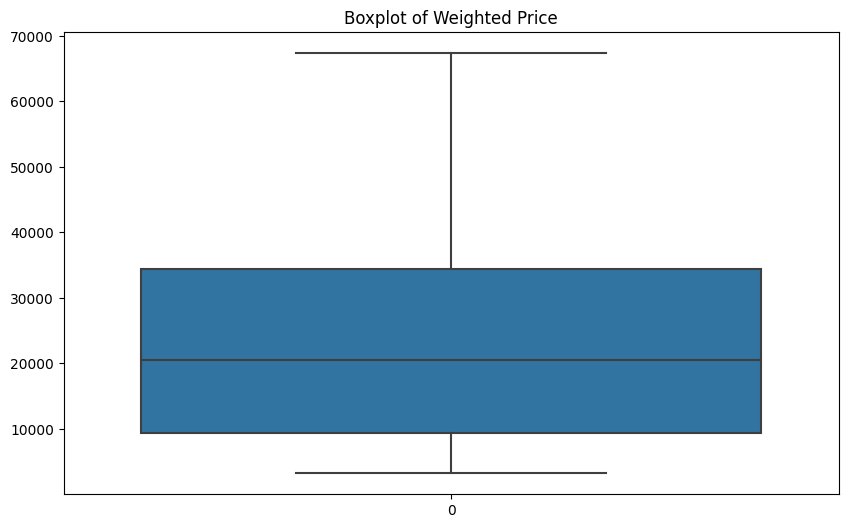

        Date        Volume  FG_Index  weighted_price
0 2018-11-15  7.032140e+09        28     5629.344848
1 2018-11-16  5.279320e+09        23     5594.207397
2 2018-11-17  4.303150e+09        24     5557.762573
3 2018-11-18  4.159680e+09        26     5599.157592
4 2018-11-19  7.039560e+09        28     5238.989990


In [ ]:
import pandas as pd
import seaborn as sns

# Assuming 'df1' is your DataFrame

# Visualize the distribution of the target variable ('weighted_price')
plt.figure(figsize=(10, 6))
sns.boxplot(df1['weighted_price'])
plt.title('Boxplot of Weighted Price')
plt.show()

# Calculate IQR for 'weighted_price'
Q1 = df1['weighted_price'].quantile(0.25)
Q3 = df1['weighted_price'].quantile(0.75)
IQR = Q3 - Q1

# Define the threshold for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows with 'weighted_price' outside the bounds
df1_no_outliers = df1[(df1['weighted_price'] >= lower_bound) & (df1['weighted_price'] <= upper_bound)]

# Display the first few rows of the cleaned dataset
print(df1_no_outliers.head())


Виконуємо стандартизацію даних

In [ ]:
from sklearn.preprocessing import StandardScaler

# Assuming 'data' is your DataFrame
features_to_standardize = ['Volume', 'FG_Index']

scaler = StandardScaler()
df1[features_to_standardize] = scaler.fit_transform(df[features_to_standardize])

             Volume     FG_Index  weighted_price
count  1.819000e+03  1819.000000     1819.000000
mean   2.864488e+10    45.171523    23577.041135
std    1.848349e+10    21.832628    16152.957690
min    3.551764e+09     5.000000     3236.860169
25%    1.653157e+10    26.000000     9354.286499
50%    2.554713e+10    43.000000    20496.826660
75%    3.618283e+10    61.000000    34437.346681
max    3.509680e+11    95.000000    67358.490237
Date              0
Volume            0
FG_Index          0
weighted_price    0
dtype: int64


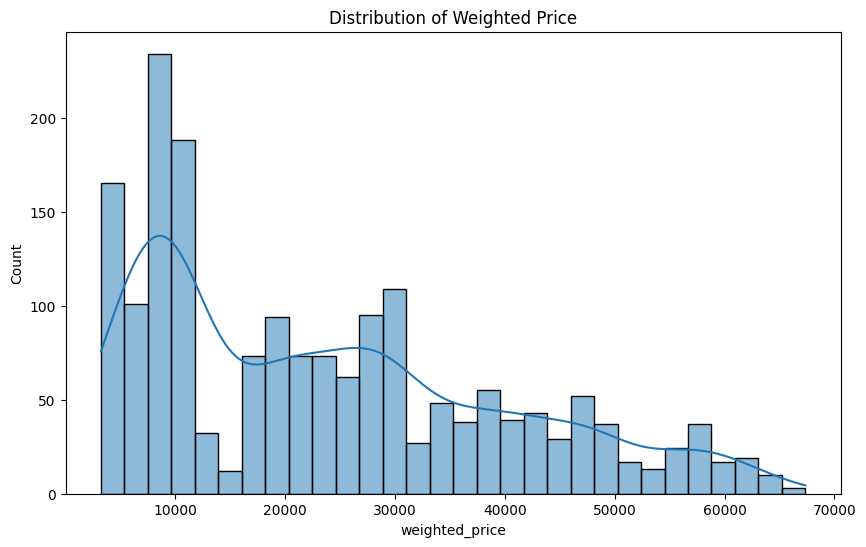

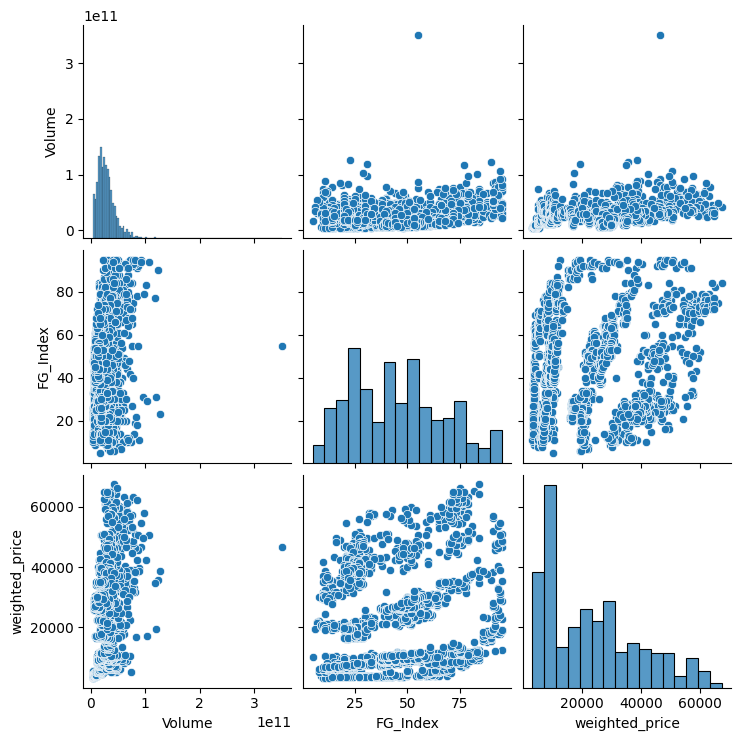

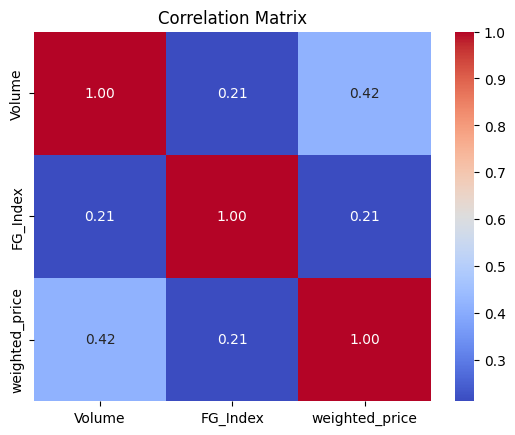

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Summary statistics
print(df1.describe())

# Check for missing values
print(df1.isnull().sum())

# Visualize the distribution of the target variable ('weighted_price')
plt.figure(figsize=(10, 6))
sns.histplot(df1['weighted_price'], bins=30, kde=True)
plt.title('Distribution of Weighted Price')
plt.show()

# Visualize the relationships between variables
sns.pairplot(df1[['Volume', 'FG_Index', 'weighted_price']])
plt.show()

# Correlation matrix
correlation_matrix = df1[['Volume', 'FG_Index', 'weighted_price']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Будуємо класичну економетричну модель

   Variable       VIF
0     const  6.580000
1    Volume  1.046676
2  FG_Index  1.046676


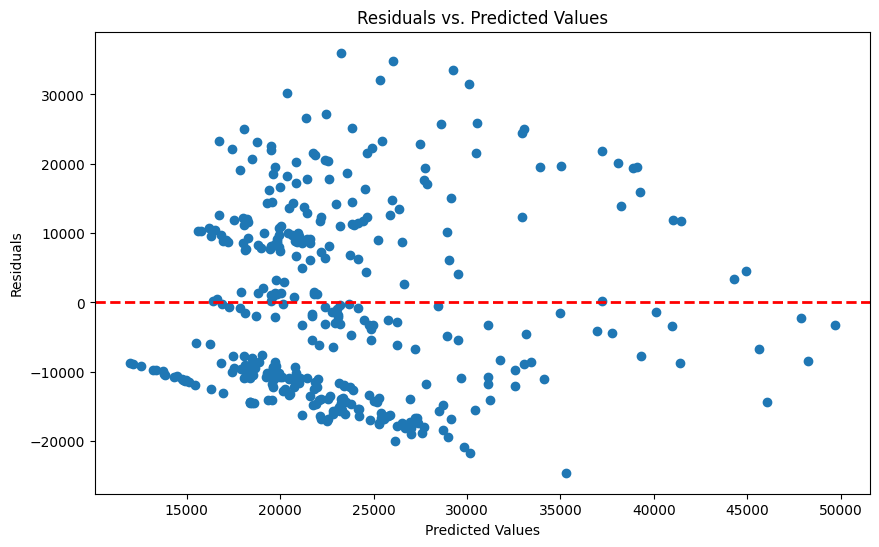

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df1' is your DataFrame

# Extract the independent variables
X = df1[['Volume', 'FG_Index']]

# Add a constant to the independent variables matrix for the statsmodels regression model
X = sm.add_constant(X)

# Extract the dependent variable
y = df1['weighted_price']

# Check for multicollinearity using Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Check for heteroscedasticity using a scatterplot of residuals
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the residuals
residuals = y_test - model.predict(X_test)

# Plot residuals against predicted values
plt.figure(figsize=(10, 6))
plt.scatter(model.predict(X_test), residuals)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()



In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming 'df1' is your DataFrame

# Extract the independent variables
X = df1[['Volume', 'FG_Index']]

# Add a constant to the independent variables matrix for the statsmodels regression model
X = sm.add_constant(X)

# Extract the dependent variable
y = df1['weighted_price']

# Check for multicollinearity using Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF:")
print(vif_data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the regression
print(model.summary())

# Predict the values for the test set
y_pred = model.predict(X_test)

# Calculate R^2
r_squared = model.rsquared
print(f"\nR^2: {r_squared}")

# Other indicators
mse = model.mse_resid  # Mean squared error of residuals
print(f"Mean Squared Error: {mse}")

# F-statistic and p-value
f_statistic = model.fvalue
p_value = model.f_pvalue
print(f"F-Statistic: {f_statistic}, p-value: {p_value}")

# T-scores and p-values for coefficients
t_scores = model.tvalues
p_values = model.pvalues
print("\nT-Scores and P-Values:")
print(pd.DataFrame({'T-Score': t_scores, 'P-Value': p_values}, index=X.columns[1:]))


VIF:
   Variable       VIF
0     const  6.580000
1    Volume  1.046676
2  FG_Index  1.046676
                            OLS Regression Results                            
Dep. Variable:         weighted_price   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     164.5
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           4.14e-65
Time:                        17:38:36   Log-Likelihood:                -16038.
No. Observations:                1455   AIC:                         3.208e+04
Df Residuals:                    1452   BIC:                         3.210e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

Хоча параметри моделі є статистично значущими, точність моделі занадто низька для того щоб використовувати її як метод прогнозування.

Створимо багатошаровий персептрон для прогнозування ціни криптовалюти на основі показників обсягу торгів та FG_Index

Mean Squared Error: 177352224.36249802
R^2 Score: 0.21091834463435166


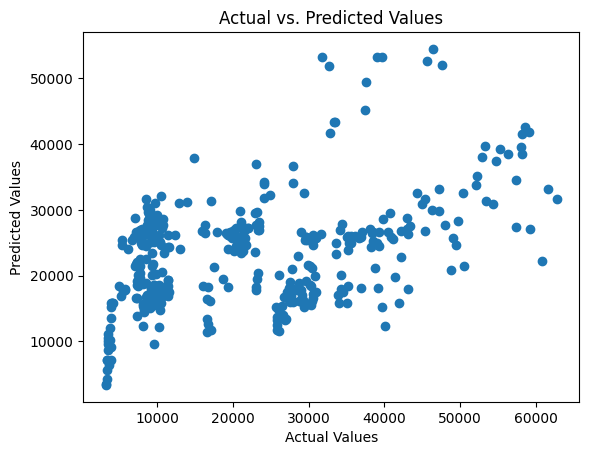

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'df1' is your DataFrame

# Extract the independent variables
X = df1[['Volume', 'FG_Index']]

# Extract the dependent variable
y = df1['weighted_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the MLP model
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50,25), max_iter=1000, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = mlp_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()


In [ ]:
Точність підвищилась лише на 3 відсотки

Створимо модель методом випадкового лісу

Mean Squared Error: 196557989.63440767
R^2 Score: 0.12546738901314236

Feature Importance:
Volume: 0.6264284262353862
FG_Index: 0.37357157376461386


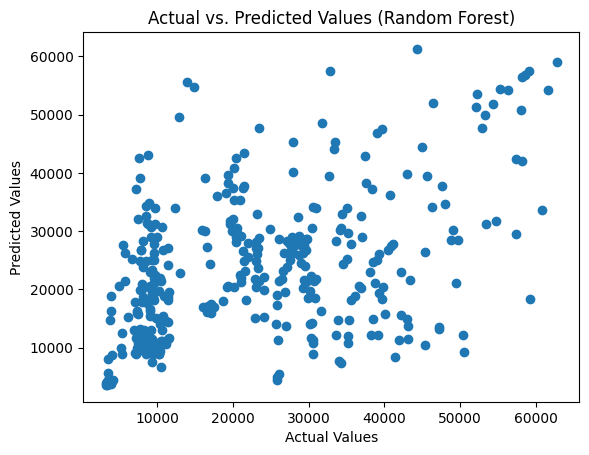

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'df1' is your DataFrame

# Extract the independent variables
X = df1[['Volume', 'FG_Index']]

# Extract the dependent variable
y = df1['weighted_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Feature importance
feature_importance = rf_model.feature_importances_
print("\nFeature Importance:")
for feature, importance in zip(X.columns, feature_importance):
    print(f"{feature}: {importance}")

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (Random Forest)")
plt.show()


Використання звичайної регресійної моделі з заданими параметрами не задовольняє меті побудови якісного прогнозу. Вплив факторів сентименту та обсягу торгів незначний і не здатний допомагати визначити ціну криптовалюти

Створення більш складних моделей з використанням багатошарового персептрону та випадкового лісу не покращило результати.